# 환경 - google colab pro gpu

#import 

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
random_state = 42

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import patsy
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 8.3 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 50.7 MB/s 
     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 45.5 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 50.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f14f06ab3337128c07c96a55bf242dcbbfd6aacd18e8f92f6683b1d811a6e339
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

#데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/따릉이/train.csv')
test = pd.read_csv('/content/drive/MyDrive/따릉이/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/따릉이/sample_submission.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 설명
- date: 날짜
- precipitation: 강수량(mm)
- temp_mean: 평균 기온(℃)
- temp_highest: 최고 기온(℃)
- temp_lowest: 최저 기온(℃)
- PM10: 미세먼지(㎍/㎥)
- PM2.5: 초미세먼지(㎍/㎥)
- humidity: 습도(%rh)
- sunshine_sum: 일조합
- sunshine_rate: 일조율
- wind_mean: 평균 풍속(m/s)
- wind_max: 최대 풍속(m/s)
- rentals : 따릉이 대여량

In [ ]:
train.isnull().sum()

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10              67
PM2.5             68
humidity           0
sunshine_sum       5
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
dtype: int64

## Basic Code

In [ ]:
year = []
month = []
day = [] 

for date in train["date"] :
    y = date.split('-')[0]
    m = date.split('-')[1]
    d = date.split('-')[2]
    
    year.append(y)
    month.append(m)
    day.append(d)

train["year"] = year 
train["month"] = month 
train["day"] = day

#fill na 
train["precipitation"] = train["precipitation"].replace(np.nan, 0)
train["PM10"] = train["PM10"].fillna(train["PM10"].mode().values[0])
train["PM2.5"] = train["PM2.5"].fillna(train["PM2.5"].mode().values[0])
train["sunshine_sum"] = train["sunshine_sum"].fillna(train["sunshine_sum"].mean())

In [ ]:
year_ =[] 
month_ = []
day_= [] 

for date in test["date"]:
    y_ = date.split("-")[0]
    m_ = date.split("-")[1]
    d_ = date.split("-")[2]

    year_.append(y_)
    month_.append(m_)
    day_.append(m_)

test["year"] = year_
test["month"] = month_
test["day"] = day_ 

test["precipitation"] = test["precipitation"].replace(np.nan, 0)
test["PM10"] = test["PM10"].fillna(test["PM10"].mode().values[0])
test["PM2.5"] = test["PM2.5"].fillna(test["PM2.5"].mode().values[0])
test["sunshine_sum"] = test["sunshine_sum"].fillna(train["sunshine_sum"].mean())

In [ ]:
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

## EDA

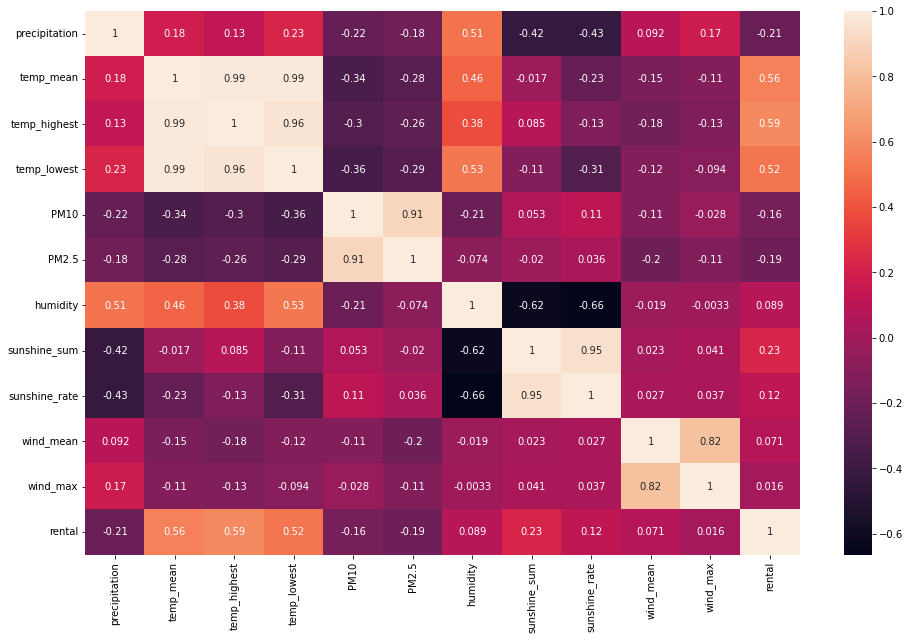

In [ ]:
plt.figure(figsize = (16, 10))
sns.heatmap(train.corr(), annot = True)
plt.show()

In [ ]:
model2 = smf.ols('rental ~ precipitation+temp_mean+temp_highest+temp_lowest+PM10+humidity+sunshine_sum+sunshine_rate+wind_mean+wind_max+year+month+day', data = train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rental   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     106.0
Date:                Wed, 06 Jul 2022   Prob (F-statistic):               0.00
Time:                        05:24:01   Log-Likelihood:                -11824.
No. Observations:                1095   AIC:                         2.376e+04
Df Residuals:                    1041   BIC:                         2.403e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1586.2996   4462.838     -0.355      0.722   -1.03e+04    7170.884
year[T.2019]   2.406e+04    929.242     25.892      0.000    2.22e+04    2.59e+04
year[T.2020]   4.068e+04   1030.839     39.459      0.000    3.87e+04    4.27e+04
month[T.02]   -1226.3586   1865.173     -0.658      0.511   -4886.287    2433.569
month[T.03]    7929.6955   2110.830      3.757      0.000    3787.729    1.21e+04
month[T.04]    2.149e+04   2490.791      8.627      0.000    1.66e+04    2.64e+04
month[T.05]    3.201e+04   2986.165     10.719      0.000    2.61e+04    3.79e+04
month[T.06]    3.928e+04   3446.009     11.399      0.000    3.25e+04     4.6e+04
month[T.07]    3.669e+04   3745.613      9.794      0.000    2.93e+04     4.4e+04
month[T.08]     2.87e+04   3922.711      7.316      0.000     2.1e+04    3.64e+04
month[T.09]    4.595e+04   3382.705     13.585      0.000    3.93e+04    5.26e+04
month[T.10]    4.794e+04   2647.668     18.108      0.000    4.27e+04    5.31e+04
month[T.11]    3.134e+04   2109.466     14.857      0.000    2.72e+04    3.55e+04
month[T.12]    1.307e+04   1840.368      7.103      0.000    9461.498    1.67e+04
day[T.02]     -3357.7928   2865.283     -1.172      0.242   -8980.181    2264.595
day[T.03]       333.3561   2871.377      0.116      0.908   -5300.990    5967.702
day[T.04]      -852.2327   2874.829     -0.296      0.767   -6493.352    4788.887
day[T.05]     -1542.8663   2871.792     -0.537      0.591   -7178.028    4092.295
day[T.06]     -2330.5366   2870.990     -0.812      0.417   -7964.124    3303.051
day[T.07]     -1792.7162   2911.222     -0.616      0.538   -7505.247    3919.815
day[T.08]      -975.3263   2877.975     -0.339      0.735   -6622.619    4671.966
day[T.09]     -3321.4931   2875.541     -1.155      0.248   -8964.011    2321.025
day[T.10]     -2450.7735   2870.326     -0.854      0.393   -8083.057    3181.510
day[T.11]       848.2440   2867.272      0.296      0.767   -4778.048    6474.536
day[T.12]     -1307.4415   2867.423     -0.456      0.649   -6934.029    4319.146
day[T.13]      -402.9784   2870.079     -0.140      0.888   -6034.777    5228.820
day[T.14]      -386.5412   2868.317     -0.135      0.893   -6014.884    5241.801
day[T.15]     -3211.8293   2868.870     -1.120      0.263   -8841.256    2417.597
day[T.16]      -267.7926   2871.933     -0.093      0.926   -5903.230    5367.645
day[T.17]      1918.4490   2865.874      0.669      0.503   -3705.099    7541.997
day[T.18]      -427.7143   2868.854     -0.149      0.882   -6057.110    5201.681
day[T.19]      -697.1516   2866.431     -0.243      0.808   -6321.793    4927.490
day[T.20]       349.3687   2876.228      0.121      0.903   -5294.497    5993.235
day[T.21]       645.1434   2871.749      0.225      0.822   -4989.933    6280.220
day[T.22]     -2952.3984   2875.682     -1.027   

__다중 공선성 확인__

다중 공선성은 없는 걸로 확인 됨

In [ ]:
y, X = patsy.dmatrices('rental ~ precipitation+temp_mean+temp_highest+temp_lowest+PM10+humidity+sunshine_sum+sunshine_rate+wind_mean+wind_max+year+month+day', train, return_type='matrix')
for i, x in enumerate(X.design_info.column_names):
    print( 'VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 147.94501092712503
VIF of year[T.2019] : 1.4233975182815968
VIF of year[T.2020] : 1.7564662667172413
VIF of month[T.02] : 1.8502422039734567
VIF of month[T.03] : 2.572213158826611
VIF of month[T.04] : 3.476425287994285
VIF of month[T.05] : 5.14787656774644
VIF of month[T.06] : 6.654130396578134
VIF of month[T.07] : 8.099276631555268
VIF of month[T.08] : 8.883274741689059
VIF of month[T.09] : 6.346966547083005
VIF of month[T.10] : 4.046946119613857
VIF of month[T.11] : 2.4934655347134167
VIF of month[T.12] : 1.9552841138915107
VIF of day[T.02] : 1.9390245442221328
VIF of day[T.03] : 1.9472815026796524
VIF of day[T.04] : 1.9519660769994502
VIF of day[T.05] : 1.9478449163520228
VIF of day[T.06] : 1.946757268784071
VIF of day[T.07] : 1.9479342587239348
VIF of day[T.08] : 1.956240554805017
VIF of day[T.09] : 1.9529339032322568
VIF of day[T.10] : 1.9458557180828389
VIF of day[T.11] : 1.94171799961409
VIF of day[T.12] : 1.9419219450502825
VIF of day[T.13] : 1.94552090478051

### 이상치 확인

__1. 스튜던트화 잔차__

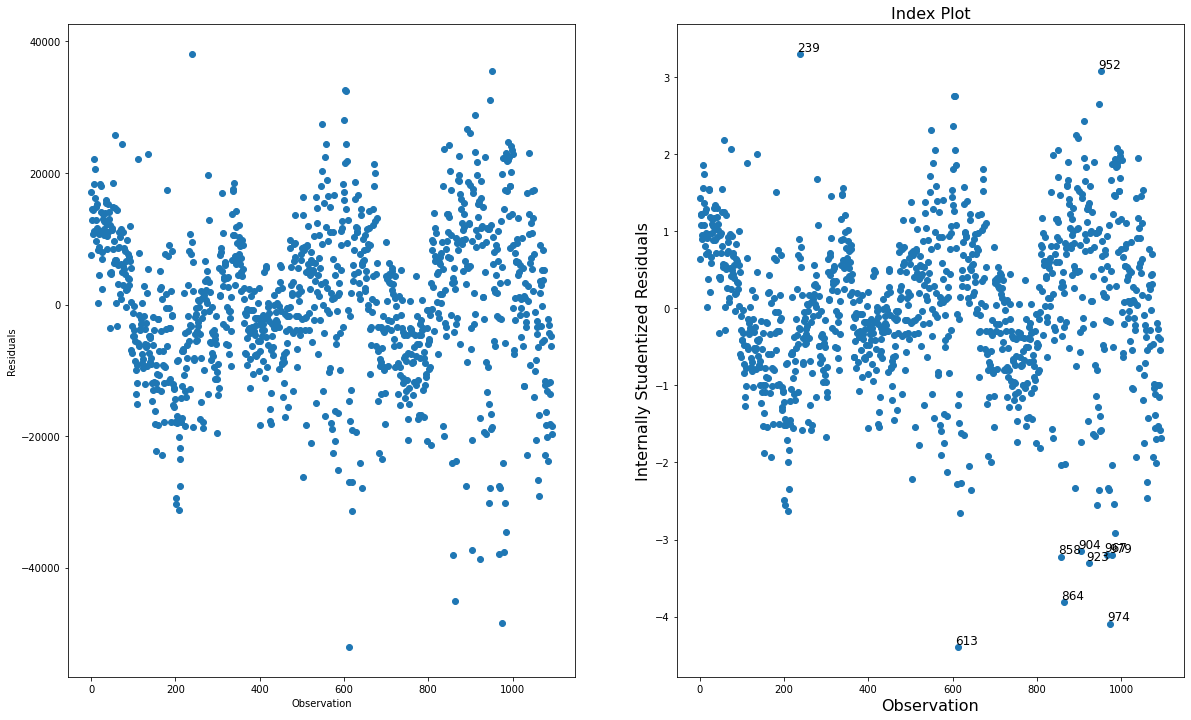

In [ ]:
inf3 = OLSInfluence(model2)
fig, ax = plt.subplots(1,2, figsize=(20, 12))
ax[0].scatter(train.index,model2.resid)
ax[0].set_xlabel('Observation')
ax[0].set_ylabel('Residuals')
inf3.plot_index('resid',threshold=3, ax = ax[1])
plt.show()

__2. Influential Point__

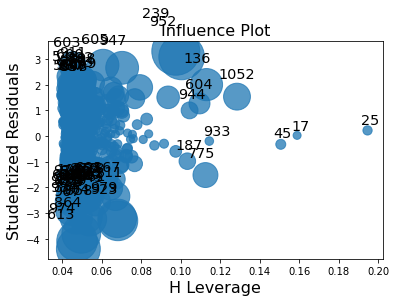

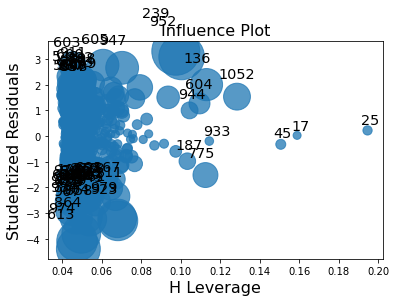

In [ ]:
inf3.plot_influence(figsize = ((20,20)))

__3. Cook's Distance__

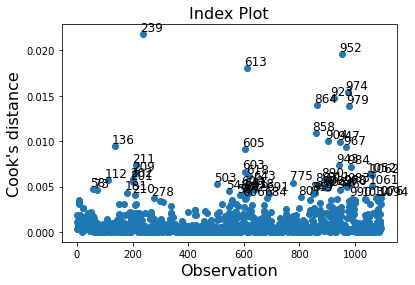

In [ ]:
inf3.plot_index('cook',threshold=4/(model2.nobs-2-1))
plt.show()

# 날짜 분류 및 기타

In [ ]:
from datetime import datetime


def process4(data):
    data["running"] = data.date.apply(lambda x : (datetime.strptime(x, "%Y-%m-%d") - datetime.strptime('2018-01-01', "%Y-%m-%d")).days)

process4(train)
process4(test)

In [ ]:
# date를 year month 분기로 split
def y_m_b(data):
    data["bungi"] = data.month.apply(lambda x : (int(x) - 1) // 3 )

y_m_b(train)
y_m_b(test)

In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
train['요일'] = train['date'].dt.dayofweek
test['요일'] = test['date'].dt.dayofweek

## Feature Engineering

### 데이터 설명
- date: 날짜
- precipitation: 강수량(mm)
- temp_mean: 평균 기온(℃)
- temp_highest: 최고 기온(℃)
- temp_lowest: 최저 기온(℃)
- PM10: 미세먼지(㎍/㎥)
- PM2.5: 초미세먼지(㎍/㎥)
- humidity: 습도(%rh)
- sunshine_sum: 일조합
- sunshine_rate: 일조율
- wind_mean: 평균 풍속(m/s)
- wind_max: 최대 풍속(m/s)
- rentals : 따릉이 대여량

__1. 주말&공휴일__

In [ ]:
!pip install pytimekr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytimekr: filename=pytimekr-0.1.0-py3-none-any.whl size=7941 sha256=b31260b183a36c9bca357195477dc211b030bfe12e6416cb3db8a18e5c745a55
  Stored in directory: /root/.cache/pip/wheels/7c/54/31/d099bce210ce51c45eeb97e149699dedc66c78eb84c01be9c2
Successfully built pytimekr


In [ ]:
from pytimekr import pytimekr

In [ ]:
kr_holidays_18 = pytimekr.holidays(year=2018)
kr_holidays_19 = pytimekr.holidays(year=2019)
kr_holidays_20 = pytimekr.holidays(year=2020)

In [ ]:
kr_holidays = kr_holidays_18 + kr_holidays_19 + kr_holidays_20

In [ ]:
a = []
for i in range(len(train)):
    if train.date[i] in kr_holidays:
        a.append(1)
    else:
        a.append(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
b = []
for i in range(len(test)):
    if test.date[i] in kr_holidays:
        b.append(1)
    else:
        b.append(2)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train['공휴일'] = a

In [ ]:
test['공휴일'] = b

In [ ]:
train[(train['공휴일']==1) & (train['요일'] == 6)]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,running,bungi,요일,공휴일
265,2018-09-23,0.0,19.4,25.3,15.6,26.0,10.0,52.9,7.4,61.2,1.6,4.3,38635,2018,09,23,265,2,6,1
489,2019-05-05,0.0,19.2,26.5,13.6,57.0,35.0,35.8,11.1,79.9,2.2,5.3,66911,2019,05,05,489,1,6,1
496,2019-05-12,0.0,21.6,28.9,14.7,47.0,29.0,36.0,12.0,85.1,1.5,3.1,73318,2019,05,12,496,1,6,1
754,2020-01-26,0.0,5.5,11.9,-0.2,28.0,20.0,56.3,7.3,72.3,2.7,6.1,22685,2020,01,26,755,0,6,1
789,2020-03-01,0.2,5.8,10.1,3.2,45.0,32.0,71.8,0.2,1.8,2.0,4.7,24431,2020,03,01,790,0,6,1


In [ ]:
for i in range(len(train)):
    if train['공휴일'][i] == 1 and train['요일'][i] == 6:
        train['공휴일'][i+1] =1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


__2 불쾌지수__

In [ ]:
# 불쾌지수 공식의 활용
def get_discomfort(humid, min_t, max_t):
    # 전체적인 탑승의 경향성을 반영하기 위해 출퇴근 시간의 사용량이 많음에도 불구하고, 평균온도로 고려합니다.
    temp = (min_t + max_t)/2
    humid = humid / 100
    
    discomfort = 1.8 * temp - 0.558 * (1 - humid) * (1.8*temp - 26) + 32
    return discomfort

train['discomfort'] = [0] * len(train)
for i in range(len(train)):
    train.discomfort[i] = get_discomfort(train.humidity[i], 
                                            train.temp_lowest[i],
                                            train.temp_highest[i])
    
test['discomfort'] = [0] * len(test)
for i in range(len(test)):
    test.discomfort[i] = get_discomfort(test.humidity[i], 
                                            test.temp_lowest[i],
                                            test.temp_highest[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def process(data):
  data["discomfort_index_label"] = data.discomfort.apply(lambda x : 0 if x < 68 else 1 if x < 75 else 2 if x < 80 else 3)

process(train)
process(test)

__3. 미세먼지 4개로 나누기__

In [ ]:
train['PM2.5등급'] = train['PM2.5'].apply(lambda x: 1 if x<16 else(2 if x<36 else(3 if x<76 else 4)))
test['PM2.5등급'] = test['PM2.5'].apply(lambda x: 1 if x<16 else(2 if x<36 else(3 if x<76 else 4)))
train['PM10등급'] = train['PM10'].apply(lambda x: 1 if x<31 else(2 if x<81 else(3 if x<151 else 4)))
test['PM10등급'] = test['PM10'].apply(lambda x: 1 if x<31 else(2 if x<81 else(3 if x<151 else 4)))

In [ ]:
a = []
for i in range(len(train)):
    if ((train['PM2.5등급'][i]==3) & (train['PM10등급'][i] == 3)) | ((train['PM2.5등급'][i]==3) & (train['PM10등급'][i] == 4)) | \
    ((train['PM2.5등급'][i]==4) & (train['PM10등급'][i] == 3)) | ((train['PM2.5등급'][i]==4) & (train['PM10등급'][i] == 4)):
        a.append(1)
    else:
        a.append(0)
    
b = []
for i in range(len(test)):
    if ((test['PM2.5등급'][i]==3) & (test['PM10등급'][i] == 3)) | ((test['PM2.5등급'][i]==3) & (test['PM10등급'][i] == 4)) | \
    ((test['PM2.5등급'][i]==4) & (test['PM10등급'][i] == 3)) | ((test['PM2.5등급'][i]==4) & (test['PM10등급'][i] == 4)):
        b.append(1)
    else:
        b.append(0)


In [ ]:
train['미세먼지_나쁨'] = a
test['미세먼지_나쁨'] = b

In [ ]:
train.drop(['day'], axis =1, inplace = True)
test.drop(['day'], axis =1, inplace = True)

### 날씨 구분
__약한 비 5mm > 장시간 노출돼야 옷이 젖을 정도__

__보통 비 10mm > 바닥에 물 고이고, 빗소리 들릴 정도__

__강한 비 20mm > 배수되지 않은 곳 비 피해 가능성__

__폭우 30 mm> 밭이나 하수구 넘치고 홍수, 침수 등 위험__

__50mm > 물을 양동이로 퍼붓는 듯 '쏟아진다'__

==========================================================

0mm = 화창 (1)

< 5mm 보슬비 (2)

< 10mm 비 (3)

< 20mm 강한비 (4)

< 30mm 폭우 (5)

눈 (6)

*눈이 올수도 있어서 최고 높은 온도가 0도 이하일때만 체크

In [ ]:
def process5(data):
  result = []
  temp = -1
  for i, j  in zip(data.precipitation , data.temp_mean):
    #눈이 내일 환경인가?
    if j <= 0 :#눈옴
      if i ==0:
        temp =1
      else:
        temp = 6
    else: # 비옴
      if i == 0:
        temp = 1
      elif i <= 5:
        temp = 2
      elif i <= 10:
        temp = 3
      elif i <= 20:
        temp = 4
      else:
        temp = 5
    result.append(temp)
  data["weather"] = result
process5(train)  
process5(test)

__4. 계절__

In [ ]:
def process3(data):
    data.loc[(data.month == '01' ) | (data.month == '02' ) | (data.month == '11' ) | (data.month == '12' ) , "season"] = 1 # 겨울
    data.loc[(data.month == '03' ) | (data.month == '04' ) | (data.month == '05' ), "season"] = 2 # 봄
    data.loc[(data.month == '06' ) | (data.month == '07' ) | (data.month == '08' ), "season"] = 3 # 여름
    data.loc[(data.month == '09' ) | (data.month == '10' ), "season"] = 4 # 가을

process3(train)
process3(test)

__5. 추운 정도 and 일교차__

In [ ]:
train['cold_measure'] = train['temp_lowest'] / train['wind_max']
test['cold_measure'] = test['temp_lowest'] / test['wind_max']

In [ ]:
train['temp_diff'] = train['temp_highest'] - train['temp_lowest'] 
test['temp_diff'] = test['temp_highest'] - test['temp_lowest']

__6. 한파__

In [ ]:
# 평균온도 -20 ~ 35까지 10도 구간으로 나눠서 라벨링

def process(data):
  data["temp_mean_label"] = data["temp_mean"].apply(lambda x : 1 if x <= 0 else 2 if x <= 10 
                                              else 3 if x <= 20 else 4)# iqr 75% 값을 넣음
  data["temp_highest_label"] = data["temp_highest"].apply(lambda x : 1 if x <= 0 else 2 if x <= 10 
                                              else 3 if x <= 20 else 4)# iqr 75% 값을 넣음

  data["temp_lowest_label"] = data["temp_lowest"].apply(lambda x : 1 if x <= 0 else 2 if x <= 10 
                                              else 3 if x <= 20 else 4)# iqr 75% 값을 넣음


process(train)
process(test)

__7. 체감온도__

In [ ]:
def process(data):
  for i in range(len(data)):
    data.loc[i, 'sensible_temperature'] =  13.12+0.6215*data.iloc[i].temp_mean-11.37*data.iloc[i].wind_mean**(0.16)+0.3965*data.iloc[i].temp_mean*data.iloc[i].wind_mean**(0.16)

process(train)
process(test)

In [ ]:
train.sensible_temperature

0       -0.230797
1       -1.273975
2       -4.813929
3       -3.766562
4       -2.416882
          ...    
1090     6.759977
1091     8.088650
1092    -0.252520
1093   -13.320510
1094    -9.550392
Name: sensible_temperature, Length: 1095, dtype: float64

__8. 바람 세기__

In [ ]:
def process(data):
  data["wind_label"] = data["wind_mean"].apply(lambda x : 1 if x<=1.6 else 2 if x<=1.9 else 3 if x<=2.4 else 4)

process(train)
process(test)

__9. 강수량__

In [ ]:
def process(data):
  data["label_precipitation"] = data["precipitation"].apply(lambda x : 0 if x <=6.3 else 1)# iqr 75% 값을 넣음


process(train)
process(test)

## Modeling

In [ ]:
train.drop(['date'], axis=1, inplace = True)
test.drop(['date'], axis=1, inplace = True)

## 스케일링

In [ ]:
scaler = StandardScaler()
x_scaled_d = scaler.fit(train.drop("rental",axis =1 ))
train_df_columns = train.drop("rental",axis =1).columns

In [ ]:
test_df_columns = test.columns
test_output = x_scaled_d.transform(test)

In [ ]:
train_output = x_scaled_d.transform(train.drop("rental",axis =1 ))

In [ ]:
train_fi = pd.DataFrame(train_output, columns = train_df_columns)
test_fi = pd.DataFrame(test_output, columns = test_df_columns)

In [ ]:
train_fi

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,...,season,cold_measure,temp_diff,temp_mean_label,temp_highest_label,temp_lowest_label,sensible_temperature,wind_label,label_precipitation,rental
0,-0.292954,-1.393122,-1.357225,-1.342314,-0.080082,-0.321136,-1.280371,0.384267,0.921466,-0.903973,...,-1.154323,-1.292469,-0.016914,-1.731832,-1.262087,-1.363386,-1.323691,-1.186636,-0.363824,4950
1,-0.292954,-1.440898,-1.546629,-1.267124,0.022659,0.056570,-1.095331,0.283363,0.793470,-0.314688,...,-1.154323,-1.128699,-0.971948,-1.731832,-1.262087,-1.363386,-1.417027,-0.316913,-0.363824,7136
2,-0.292954,-1.717999,-1.754974,-1.530288,-0.234193,-0.170054,-1.076189,0.459944,0.988511,0.274596,...,-1.154323,-1.534469,-0.767298,-1.731832,-2.343453,-1.363386,-1.733759,0.552810,-0.363824,7156
3,-0.292954,-1.717999,-1.783385,-1.680667,0.176771,0.207652,-1.031524,-0.145477,0.232729,-0.903973,...,-1.154323,-1.695625,-0.323889,-1.731832,-2.343453,-1.363386,-1.640047,-1.186636,-0.363824,7102
4,-0.292954,-1.555561,-1.565570,-1.389308,0.793216,1.038604,-0.686966,0.359041,0.860516,-0.462010,...,-1.154323,-1.367716,-0.596756,-1.731832,-1.262087,-1.363386,-1.519287,-0.316913,-0.363824,7705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,-0.292954,-0.714703,-0.770071,-0.731399,1.769255,1.567391,0.238236,-0.221155,0.159589,-0.314688,...,-1.154323,-0.643071,-0.119239,-0.774076,-1.262087,-0.416710,-0.698202,-0.316913,-0.363824,37103
1091,-0.183892,-0.628706,-0.637488,-0.468235,1.563773,1.718473,0.825261,0.308589,0.823946,-0.903973,...,-1.154323,-0.341715,-0.596756,-0.774076,-0.180721,-0.416710,-0.579321,-1.186636,-0.363824,46912
1092,-0.276175,-1.259349,-1.309874,-1.445700,1.717884,1.869556,0.742312,-1.709482,-1.714627,1.305843,...,-1.154323,-1.177646,0.528819,-0.774076,-1.262087,-1.363386,-1.325634,1.422534,-0.363824,35747
1093,-0.292954,-2.310421,-2.304247,-2.075412,0.176771,-0.472218,-0.233936,0.384267,0.921466,3.073695,...,-1.154323,-1.552826,-0.767298,-1.731832,-2.343453,-1.363386,-2.494872,1.422534,-0.363824,22488


In [ ]:
train_fi['rental'] = train.rental

In [ ]:
# train data
X = train_fi.drop(['rental'], axis=1)
y = train_fi.rental

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

__MODEL__

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow import keras

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

def build_model(): 
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])
    return model

In [ ]:
# # batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='mae', patience=10),]

In [ ]:
import numpy as np

k = 3


num_val_samples = len(X_train) // k
num_epochs = 250
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    
    model.fit(partial_train_data, partial_train_targets,  # 모델 훈련
              epochs=num_epochs, batch_size=1, callbacks=callbacks,verbose=1) # batch_size 1
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
    all_scores.append(val_mae)

처리중인 폴드 # 0
Epoch 1/250
548/548 [==============================] - 4s 4ms/step - loss: 46768.9531 - mae: 46768.9531
Epoch 2/250
548/548 [==============================] - 3s 5ms/step - loss: 25544.3066 - mae: 25544.3066
Epoch 3/250
548/548 [==============================] - 2s 4ms/step - loss: 16537.2363 - mae: 16537.2363
Epoch 4/250
548/548 [==============================] - 2s 4ms/step - loss: 11939.3477 - mae: 11939.3477
Epoch 5/250
548/548 [==============================] - 2s 4ms/step - loss: 9993.1318 - mae: 9993.1318
Epoch 6/250
548/548 [==============================] - 2s 4ms/step - loss: 9230.3926 - mae: 9230.3926
Epoch 7/250
548/548 [==============================] - 3s 5ms/step - loss: 8657.7881 - mae: 8657.7881
Epoch 8/250
548/548 [==============================] - 2s 4ms/step - loss: 8294.6299 - mae: 8294.6299
Epoch 9/250
548/548 [==============================] - 3s 5ms/step - loss: 8026.4746 - mae: 8026.4746
Epoch 10/250
548/548 [==============================] - 3s 5ms

In [ ]:
temp = model.predict(test_fi)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/따릉이/sample_submission.csv')
sample_submission["rental"] = temp
sample_submission.to_csv('ddareung-06-30_01.csv', index=False)

In [ ]:
sample_submission

,date,rental
0,2021-01-01,24746.746094
1,2021-01-02,28261.943359
2,2021-01-03,20454.681641
3,2021-01-04,30756.882812
4,2021-01-05,24601.656250
...,...,...
360,2021-12-27,43244.722656
361,2021-12-28,46234.031250
362,2021-12-29,59045.199219
363,2021-12-30,55282.503906
